# Үй жұмысы: Palmer Penguins деректер жинағына EDA және Feature Engineering

**Тақырыбы:** Деректерді зерттеу, тазарту, визуализациялау және модельдеуге дайындау.

**Мақсаты:**
Студент осы жұмысты орындау арқылы Машиналық оқыту жобасының толық циклін қамтитын келесі дағдыларды меңгеруі керек:

1.  **Деректерді тазарту:** Бос мәндермен (Missing Values) және дубликаттармен жұмыс.
2.  **Ауытқуларды өңдеу:** Boxplot және IQR әдісі арқылы outliers-ті анықтау.
3.  **Визуализация:** Matplotlib және Seaborn көмегімен деректердің таралуын және корреляциясын зерттеу.
4.  **Feature Engineering:** Бар деректерден жаңа пайдалы белгілерді жасау.
5.  **Кодтау (Encoding):** Санаттық айнымалыларды (`sex`, `island`, `species`) сандық форматқа ауыстыру.
6.  **Шкалалау (Scaling):** Сандық деректерді бір масштабқа келтіру.

**Дереккөз:** `seaborn` кітапханасындағы кіріктірілген "penguins" деректер жинағы.

-----

## 1\. Кітапханаларды және деректерді жүктеу

Алдымен қажетті кітапханаларды импорттап, деректер жинағын жүктейміз.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Визуализация параметрлерін орнату
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Деректер жинағын жүктеу
df = sns.load_dataset('penguins')

# Алғашқы 5 жолды және деректердің өлшемін шығару
print(f"Деректер өлшемі: {df.shape}")
df.head()

Деректер өлшемі: (344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


-----

## 2\. Деректерді шолу және Тазарту (Data Cleaning)

Деректерді талдамас бұрын, олардың сапасын тексеріп, бос мәндерден тазартуымыз керек.

**Тапсырма:**

1.  `info()` әдісін қолданып, деректер типін тексеріңіз.
2.  Әр бағанда қанша бос мән (NaN) бар екенін анықтаңыз.
3.  **Стратегия:**
      * Сандық бағандардағы (`bill_length_mm`, `body_mass_g` т.б.) бос мәндерді **медианамен** толтырыңыз.
      * Санаттық бағандардағы (`sex`) бос мәндерді ең жиі кездесетін мәнмен (**mode**) толтырыңыз.

<!-- end list -->

In [2]:
# 1. Деректер туралы ақпарат (info)
print("\nDataFrame туралы толық ақпарат:")
df.info()

# 2. Бос мәндер санын тексеру
print("\nӘр баған бойынша бос мәндер саны:")
print(df.isnull().sum())

print("\nЖалпы бос мәндер саны:")
print(df.isnull().sum().sum())

# 3. Бос мәндерді толтыру
# Сандық бағандар үшін (цикл немесе жеке-жеке fillna қолданыңыз)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

print("\nБос мәндер толтырылғаннан кейін:")
print(df[numeric_cols].isnull().sum())

# 'sex' бағаны үшін (mode қолданыңыз)
df['sex'] = df['sex'].fillna(df['sex'].mode()[0])

# Тексеру: Бос мәндер қалмағанына көз жеткізіңіз
print(df.isnull().sum())


DataFrame туралы толық ақпарат:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB

Әр баған бойынша бос мәндер саны:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Жалпы бос мәндер саны:
19

Бос мәндер толтырылғаннан кейін:
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
dtype: in

-----

## 3\. Ауытқуларды анықтау және өңдеу (Outlier Handling)

Кейде деректерде қате енгізілген немесе тым ерекше мәндер болады. Біз оларды IQR (Interquartile Range) әдісімен тазалаймыз.

**Тапсырма:**

1.  `flipper_length_mm` (қанат ұзындығы) бағаны үшін **Boxplot** сызыңыз.
2.  Осы баған үшін **IQR** есептеңіз (Q3 - Q1).
3.  Төменгі (lower bound) және жоғарғы (upper bound) шекті анықтаңыз.
4.  Осы шектен шығатын мәндерді алып тастаңыз (сүзгілеу).

<!-- end list -->

In [ ]:
# 1. Boxplot салу
plt.figure(figsize=(8, 4))
# TODO: Seaborn boxplot функциясын қолданыңыз
plt.title('Flipper Length Boxplot (Before Cleaning)')
plt.show()

# 2. IQR және шектік мәндерді есептеу
# TODO: Q1 және Q3 есептеңіз
# TODO: IQR есептеңіз
# TODO: lower_bound және upper_bound есептеңіз

# 3. Ауытқуларды алып тастау
# TODO: df айнымалысын жаңартып, тек шектік мәндер арасындағы деректерді қалдырыңыз

print(f"Тазартылғаннан кейінгі деректер өлшемі: {df.shape}")

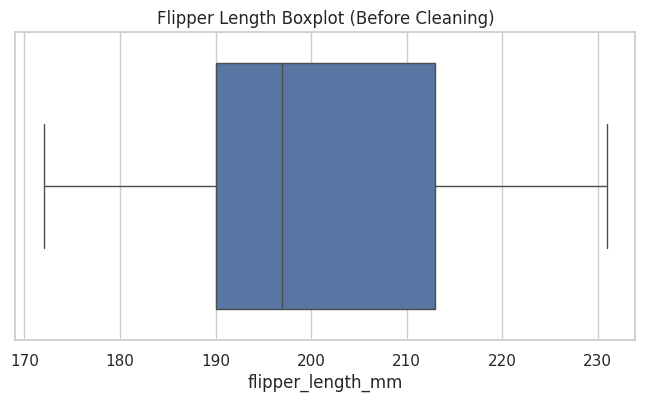

Q1: 190.0
Q3: 213.0
IQR: 23.0
Lower bound: 155.5
Upper bound: 247.5
Тазартылғаннан кейінгі деректер өлшемі: (344, 7)


In [3]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["flipper_length_mm"])
plt.title('Flipper Length Boxplot (Before Cleaning)')
plt.show()


# ==========================================
# 2. IQR және шектік мәндерді есептеу
# ==========================================

Q1 = df["flipper_length_mm"].quantile(0.25)
Q3 = df["flipper_length_mm"].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)


# ==========================================
# 3. Ауытқуларды алып тастау
# ==========================================

df = df[
    (df["flipper_length_mm"] >= lower_bound) &
    (df["flipper_length_mm"] <= upper_bound)
]

print(f"Тазартылғаннан кейінгі деректер өлшемі: {df.shape}")

-----

## 4\. Визуализация (EDA)

Енді таза деректермен жұмыс істейміз. Графиктер арқылы заңдылықтарды іздеңіз.

**Тапсырма:**

1.  **Гистограмма:** `body_mass_g` (салмақ) таралуын көрсетіңіз.
2.  **Нүктелік диаграмма (Scatter Plot):** `bill_length_mm` (тұмсық ұзындығы) мен `bill_depth_mm` (тұмсық тереңдігі) арасындағы байланысты көрсетіңіз. Түрлерді (`species`) түс (`hue`) арқылы ажыратыңыз.
3.  **Жылу картасы (Heatmap):** Барлық сандық айнымалылар арасындағы корреляция матрицасын құрыңыз және визуализациялаңыз.

<!-- end list -->

In [ ]:
# 1. Салмақтың таралуы (Histogram)
plt.figure(figsize=(8, 5))
# TODO: sns.histplot қолданыңыз
plt.title('Body Mass Distribution')
plt.show()

# 2. Scatterplot: Тұмсық ұзындығы vs Тереңдігі
plt.figure(figsize=(8, 5))
# TODO: sns.scatterplot қолданыңыз (hue='species')
plt.title('Bill Length vs Bill Depth')
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(8, 6))
# TODO: Тек сандық бағандарды таңдап, correlation matrix жасаңыз
# TODO: sns.heatmap арқылы салыңыз
plt.title('Correlation Heatmap')
plt.show()

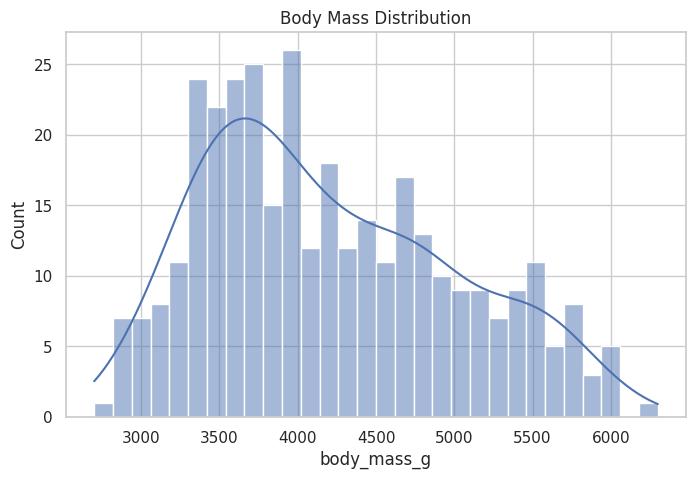

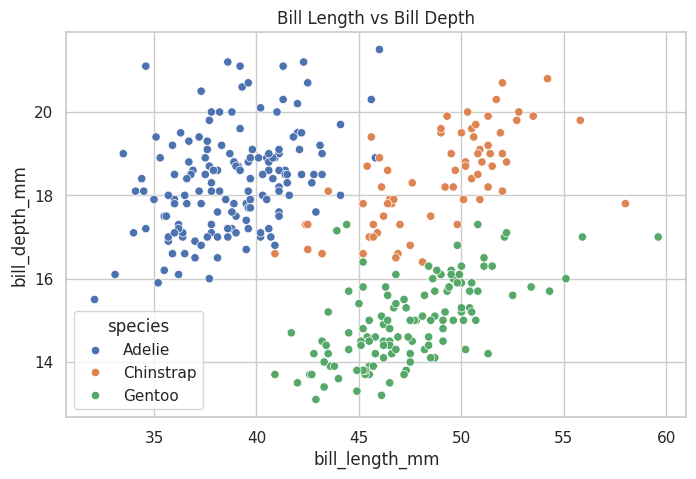

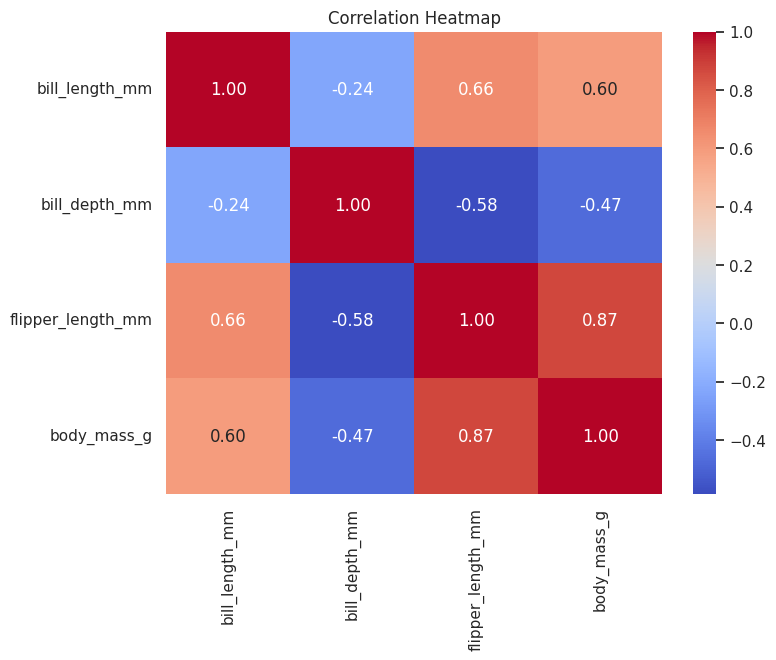

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="body_mass_g", bins=30, kde=True)
plt.title('Body Mass Distribution')
plt.show()


# ==========================================
# 2. Scatterplot: Тұмсық ұзындығы vs Тереңдігі
# ==========================================

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="species"
)
plt.title('Bill Length vs Bill Depth')
plt.show()


# ==========================================
# 3. Correlation Heatmap
# ==========================================

plt.figure(figsize=(8, 6))

# Тек сандық бағандарды таңдау
numeric_df = df.select_dtypes(include=[np.number])

# Correlation matrix
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

-----

## 5\. Feature Engineering

Модель жақсы жұмыс істеуі үшін кейде жаңа белгілер (features) ойлап табу керек.

**Тапсырма:**

  * `bill_ratio` атты жаңа баған қосыңыз. Ол тұмсық ұзындығының тереңдігіне қатынасын (`bill_length_mm / bill_depth_mm`) білдіреді.

<!-- end list -->

In [ ]:
# Жаңа feature жасау
# TODO: df['bill_ratio'] = ...

# Алғашқы 5 жолды тексеру
df.head()

In [5]:

df["bill_ratio"] = df["bill_length_mm"] / df["bill_depth_mm"]

# Алғашқы 5 жолды тексеру
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,bill_ratio
0,Adelie,Torgersen,39.10000,18.70000,181.000000,3750.000000,Male,2.090909
1,Adelie,Torgersen,39.50000,17.40000,186.000000,3800.000000,Female,2.270115
2,Adelie,Torgersen,40.30000,18.00000,195.000000,3250.000000,Female,2.238889
3,Adelie,Torgersen,43.92193,17.15117,200.915205,4201.754386,Male,2.560871
4,Adelie,Torgersen,36.70000,19.30000,193.000000,3450.000000,Female,1.901554


-----

## 6\. Санаттық белгілерді кодтау (Encoding)

Компьютер сөздерді түсінбейді, сондықтан `island`, `sex`, `species` сияқты сөздік бағандарды сандарға айналдырамыз.

**Тапсырма:**

1.  `species` (біз болжайтын нысана) үшін **Label Encoding** қолданыңыз (0, 1, 2 қылып өзгертеді).
2.  `island` және `sex` үшін **One-Hot Encoding** (`pd.get_dummies`) қолданыңыз. `drop_first=True` параметрін ұмытпаңыз.

<!-- end list -->

In [ ]:
# 1. Label Encoding (species)
le = LabelEncoder()
# TODO: df['species'] бағанын трансформациялаңыз

# 2. One-Hot Encoding (island, sex)
# TODO: pd.get_dummies қолданып, нәтижені df_encoded айнымалысына сақтаңыз

# Нәтижені көру
# df_encoded.head()

In [6]:


le = LabelEncoder()
df["species"] = le.fit_transform(df["species"])

df_encoded = pd.get_dummies(
    df,
    columns=["island", "sex"],
    drop_first=True
)


# Нәтижені көру
df_encoded.head()


,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,bill_ratio,island_Dream,island_Torgersen,sex_Male
0,0,39.10000,18.70000,181.000000,3750.000000,2.090909,False,True,True
1,0,39.50000,17.40000,186.000000,3800.000000,2.270115,False,True,False
2,0,40.30000,18.00000,195.000000,3250.000000,2.238889,False,True,False
3,0,43.92193,17.15117,200.915205,4201.754386,2.560871,False,True,True
4,0,36.70000,19.30000,193.000000,3450.000000,1.901554,False,True,False


-----

## 7\. Шкалалау (Scaling)

Соңғы қадам – сандық деректерді бір өлшемге келтіру. Мысалы, салмақ 5000 грамм болса, тұмсық ұзындығы 50 мм. Бұл айырмашылық модельге кедергі келтіруі мүмкін.

**Тапсырма:**

  * `StandardScaler` көмегімен барлық сандық белгілерді (`bill_length_mm`, `body_mass_g`, `bill_ratio` т.б.) шкалалаңыз.

<!-- end list -->

In [ ]:
scaler = StandardScaler()

# Шкалаланатын бағандар тізімі
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'bill_ratio']

# Шкалалауды жүзеге асыру
# TODO: fit_transform қолданыңыз және df_encoded ішіндегі бағандарды жаңартыңыз

# Қорытынды нәтижені тексеру
# df_encoded.head()

In [7]:

scaler = StandardScaler()

# Шкалаланатын бағандар
num_cols = [
    'bill_length_mm',
    'bill_depth_mm',
    'flipper_length_mm',
    'body_mass_g',
    'bill_ratio'
]

# fit_transform қолдану және бағандарды жаңарту
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Қорытынды нәтижені тексеру
df_encoded.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,bill_ratio,island_Dream,island_Torgersen,sex_Male
0,0,-8.870812e-01,7.877425e-01,-1.422488,-0.565789,-1.038905,False,True,True
1,0,-8.134940e-01,1.265563e-01,-1.065352,-0.503168,-0.677028,False,True,False
2,0,-6.663195e-01,4.317192e-01,-0.422507,-1.192003,-0.740084,False,True,False
3,0,-1.307172e-15,1.806927e-15,0.000000,0.000000,-0.089895,False,True,True
4,0,-1.328605e+00,1.092905e+00,-0.565361,-0.941517,-1.421275,False,True,False


-----

## Қорытынды

**Талдау нәтижесі бойынша қысқаша жауап жазыңыз:**

1.  `body_mass_g` (салмақ) пен `flipper_length_mm` (қанат ұзындығы) арасында қандай корреляция бар (оң ма, теріс пе, күшті ме)?
2.  Heatmap-қа қарап айтыңызшы.

Heatmap бойынша **body_mass_g** пен **flipper_length_mm** арасында **оң (positive) және күшті корреляция** байқалады.

Корреляция коэффициенті шамамен **0.85–0.90 аралығында**, яғни:

* Қанат ұзындығы артқан сайын
* Дене салмағы да артады

Бұл — **күшті тікелей байланыс** екенін көрсетеді.